In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

import jax.numpy as np
from jax import lax, random, vmap
from jax.config import config; config.update("jax_platform_name", "cpu")

import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro.handlers import sample, seed, substitute, trace
from numpyro.hmc_util import initialize_model
from numpyro.mcmc import mcmc

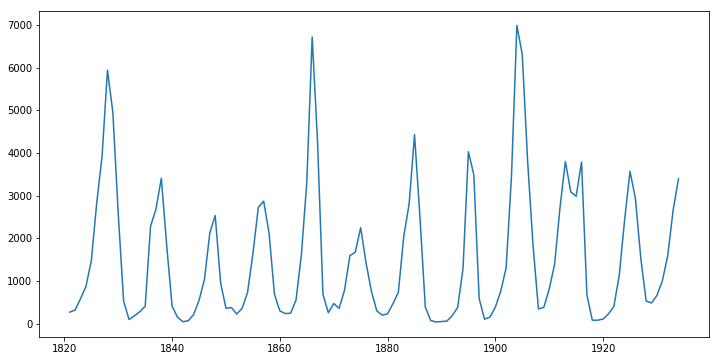

In [2]:
lynx = pd.read_csv("lynx.csv", index_col=0)
data = lynx["value"].values
plt.figure(figsize=(12, 6))
plt.plot(lynx["time"], data);

In [3]:
# Source: https://github.com/cbergmeir/Rlgt/blob/master/Rlgt/R/rlgtcontrol.R
# model params
CAUCHY_SD_DIV = 150
MIN_NU = 2
MAX_NU = 20
MIN_POW_TREND = -0.5
MAX_POW_TREND = 1
POW_TREND_ALPHA = 1
POW_TREND_BETA = 1
MIN_SIGMA = 1e-10

# hmc params
ADAPT_DELTA = 0.9
MAX_TREE_DEPTH = 12
NUM_OF_ITER = 2000

# data
ADD_JITTER = True
MIN_VAL = 1e-30
MAX_VAL = 1e38

y = data
N = len(y)
if ADD_JITTER:
    y = y + dist.Normal(0, abs(min(y)) * 0.0001).sample(key=random.PRNGKey(1), size=(N,))

In [4]:
def get_exp_val_and_smoothed_innov_size(y, l_init, b_init, innov_size_init, coef_trend, pow_trend,
                                        loc_trend_fract, lev_sm, b_sm, innov_sm,
                                        USE_SMOOTHED_ERROR):
    def scan_fn(carry, y_t):
        l, b, smoothed_innov_size = carry
        exp_val = l + coef_trend * l ** pow_trend + loc_trend_fract * b
        exp_val = np.clip(exp_val, a_min=0.)
        l_tmp = l
        l = lev_sm * y_t + (1 - lev_sm) * l
        b = b_sm * (l - l_tmp) + (1 - b_sm) * b
        if USE_SMOOTHED_ERROR:
            smoothed_innov_size = (innov_sm * np.abs(y_t - exp_val)
                                   + (1 - innov_sm) * smoothed_innov_size)
        return (l, b, smoothed_innov_size), (exp_val, smoothed_innov_size)

    last_carry, (exp_val, smoothed_innov_size) = lax.scan(
        scan_fn, (l_init, b_init, innov_size_init), y)
    smoothed_innov_size = np.concatenate([np.expand_dims(innov_size_init, axis=-1),
                                          smoothed_innov_size])
    return exp_val, smoothed_innov_size, last_carry

In [5]:
def lgt(y, USE_SMOOTHED_ERROR=False):
    CAUCHY_SD = np.max(y) / CAUCHY_SD_DIV

    nu = sample("nu", dist.Uniform(MIN_NU, MAX_NU))
    lev_sm = sample("lev_sm", dist.Uniform(0, 1))
    b_sm = sample("b_sm", dist.Uniform(0, 1))
    loc_trend_fract = sample("loc_trend_fract", dist.Uniform(0, 1))

    sigma = sample("sigma", dist.HalfCauchy(CAUCHY_SD))
    offset_sigma = sample("offset_sigma", dist.TruncatedCauchy(low=MIN_SIGMA, loc=MIN_SIGMA,
                                                               scale=CAUCHY_SD))
    coef_trend = sample("coef_trend", dist.Cauchy(0, CAUCHY_SD))
    pow_trend_beta = sample("pow_trend_beta", dist.Beta(POW_TREND_ALPHA, POW_TREND_BETA))

    if USE_SMOOTHED_ERROR:
        innov_sm = sample("innov_sm", dist.Uniform(0, 1))
        innov_size_init = sample("innov_size_init",
                                 dist.TruncatedCauchy(low=0, loc=y[0] / 100, scale=CAUCHY_SD))
    else:
        innov_sm = 0.
        innov_size_init = np.array(1.)

    l_init = y[0]
    b_init = sample("b_init", dist.Cauchy(0, CAUCHY_SD))
    pow_trend = (MAX_POW_TREND - MIN_POW_TREND) * pow_trend_beta + MIN_POW_TREND
    exp_val, smoothed_innov_size, last_carry = get_exp_val_and_smoothed_innov_size(
        y[1:], l_init, b_init, innov_size_init, coef_trend, pow_trend, loc_trend_fract,
        lev_sm, b_sm, innov_sm, USE_SMOOTHED_ERROR)

    if USE_SMOOTHED_ERROR:
        sample("y", dist.StudentT(nu, exp_val, sigma * smoothed_innov_size[:-1] + offset_sigma),
               obs=y[1:])
    else:
        powx = sample("powx", dist.Uniform(0, 1))
        sample("y", dist.StudentT(nu, exp_val, sigma * exp_val ** powx + offset_sigma),
               obs=y[1:])
    return last_carry

In [6]:
# Ref: https://github.com/cbergmeir/Rlgt/blob/master/Rlgt/R/forecast.rlgtfit.R#L333
def lgt_forecast(asample, y, USE_SMOOTHED_ERROR, future=10):
    l, b, smoothed_innov_size = substitute(lgt, asample)(y, USE_SMOOTHED_ERROR)
    pow_trend = (MAX_POW_TREND - MIN_POW_TREND) * asample['pow_trend_beta'] + MIN_POW_TREND
    yf = []
    for t in range(future):
        exp_val = (l + asample['coef_trend'] * np.abs(l) ** pow_trend
                   + asample['loc_trend_fract'] * b)
        if USE_SMOOTHED_ERROR:
            omega = asample['sigma'] * smoothed_innov_size + asample['offset_sigma']
        else:
            omega = asample['sigma'] * exp_val ** asample['powx'] + asample['offset_sigma']
        yf = sample('yf[{}]'.format(t), dist.StudentT(asample['nu'], exp_val, omega))

        yf = np.clip(yf, a_min=MIN_VAL, a_max=MAX_VAL)
        l_tmp = l
        l = np.clip(asample['lev_sm'] * yf + (1 - asample['lev_sm']) * l, a_min=MIN_VAL)
        l = np.where(l_tmp > MIN_VAL, l, l_tmp)
        b = np.where(l_tmp > MIN_VAL, asample['b_sm'] * (l - l_tmp) + (1 - asample['b_sm']) * b, b)


def forecast(asample, rng, y, USE_SMOOTHED_ERROR, future):
    model = seed(lgt_forecast, rng)
    forecast_trace = trace(model).get_trace(asample, y, USE_SMOOTHED_ERROR, future)
    return {name: site['value'] for name, site in forecast_trace.items() if 'yf' in name}

#### `USE_SMOOTHED_ERROR=True`

In [7]:
USE_SMOOTHED_ERROR = True

init_params, potential_fn, constrain_fn = initialize_model(
    random.PRNGKey(2), lgt, y, USE_SMOOTHED_ERROR)

samples = mcmc(num_warmup=NUM_OF_ITER // 2, num_samples=NUM_OF_ITER // 2,
               init_params=init_params, potential_fn=potential_fn, constrain_fn=constrain_fn,
               target_accept_prob=ADAPT_DELTA, max_tree_depth=MAX_TREE_DEPTH)



                           mean         sd       5.5%      94.5%      n_eff       Rhat
              b_init     -15.97     108.58    -138.11     149.52     393.34       1.00
                b_sm       0.94       0.05       0.87       1.00     862.05       1.00
          coef_trend     111.13     123.24       4.98     202.94     113.45       1.01
     innov_size_init      81.06     134.77       0.13     174.08     708.80       1.00
            innov_sm       0.95       0.04       0.90       1.00    1016.81       1.00
              lev_sm       0.94       0.05       0.87       1.00     533.95       1.00
     loc_trend_fract       0.41       0.10       0.25       0.57     460.04       1.00
                  nu       2.87       1.48       2.00       3.72     258.22       1.00
        offset_sigma     178.89      72.73      73.29     281.55     327.50       1.00
      pow_trend_beta       0.39       0.11       0.24       0.56      73.84       1.03
               sigma       0.77       0.1

In [8]:
rngs = random.split(random.PRNGKey(3), samples['b_init'].shape[0])
forecast_marginal = vmap(
    lambda asample, rng: forecast(asample, rng, y, USE_SMOOTHED_ERROR, future=10))(samples, rngs)
forecast_values = np.stack(list(forecast_marginal.values()), axis=1)

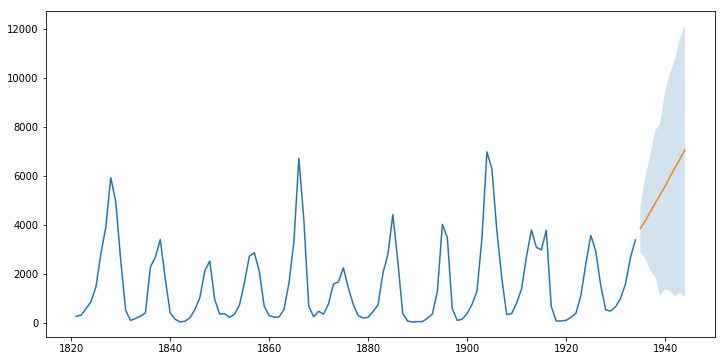

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(lynx['time'], data)
t_futures = range(lynx['time'].iloc[-1] + 1, lynx['time'].iloc[-1] + 11)
forecast_mean = np.mean(forecast_values, axis=0)
forecast_hpd_low, forecast_hpd_high = hpdi(forecast_values)
plt.plot(t_futures, forecast_mean)
plt.fill_between(t_futures, forecast_hpd_low, forecast_hpd_high, alpha=0.2);

#### `USE_SMOOTHED_ERROR=False`

In [7]:
USE_SMOOTHED_ERROR = False

init_params, potential_fn, constrain_fn = initialize_model(
    random.PRNGKey(3), lgt, y, USE_SMOOTHED_ERROR)

samples = mcmc(num_warmup=NUM_OF_ITER // 2, num_samples=NUM_OF_ITER // 2,
               init_params=init_params, potential_fn=potential_fn, constrain_fn=constrain_fn,
               target_accept_prob=ADAPT_DELTA, max_tree_depth=MAX_TREE_DEPTH)



                           mean         sd       5.5%      94.5%      n_eff       Rhat
              b_init     -21.60     194.24    -317.04     250.55     516.61       1.00
                b_sm       0.97       0.03       0.94       1.00     531.84       1.00
          coef_trend      42.94      29.49      10.10      74.50     277.53       1.00
              lev_sm       0.96       0.03       0.92       1.00     280.23       1.00
     loc_trend_fract       0.26       0.05       0.18       0.33     250.96       1.00
                  nu      12.18       4.06       5.91      18.56     480.31       1.00
        offset_sigma      14.02      11.44       0.03      28.82     377.93       1.00
      pow_trend_beta       0.51       0.07       0.39       0.62     311.22       1.00
                powx       0.93       0.05       0.86       1.00     375.88       1.00
               sigma       0.91       0.39       0.45       1.39     423.19       1.00


In [8]:
rngs = random.split(random.PRNGKey(3), samples['b_init'].shape[0])
forecast_marginal = vmap(
    lambda asample, rng: forecast(asample, rng, y, USE_SMOOTHED_ERROR, future=10))(samples, rngs)
forecast_values = np.stack(list(forecast_marginal.values()), axis=1)

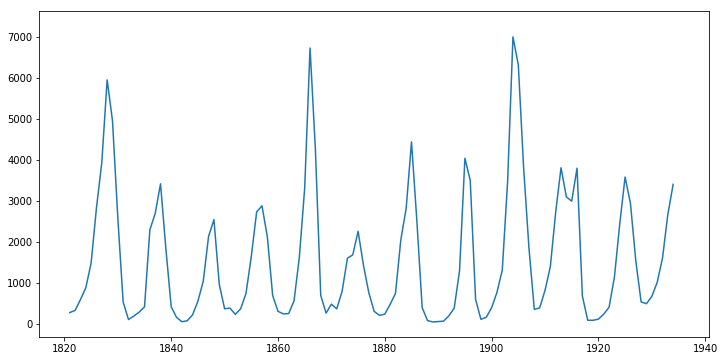

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(lynx['time'], data)
t_futures = range(lynx['time'].iloc[-1] + 1, lynx['time'].iloc[-1] + 11)
forecast_mean = np.mean(forecast_values, axis=0)
forecast_hpd_low, forecast_hpd_high = hpdi(forecast_values)
plt.plot(t_futures, forecast_mean)
plt.fill_between(t_futures, forecast_hpd_low, forecast_hpd_high, alpha=0.2);

TODO: debug why we get `nan` in prediction

In [11]:
forecast_values

DeviceArray([[ 5.66466895e+03,  8.05541016e+03,  1.61697402e+04, ...,
                          nan,             nan,             nan],
             [ 7.39762549e+03,  1.19742764e+04,  1.74386641e+04, ...,
                          nan,             nan,             nan],
             [ 3.99874951e+03,  6.12452246e+03,  2.58602295e+03, ...,
               1.18977005e+02, -9.56147614e+01,             nan],
             ...,
             [ 1.71645361e+03,  1.67482092e+03,  2.91293604e+03, ...,
               3.45274297e+04,  4.77835703e+04,  9.63033125e+04],
             [ 3.06422900e+03,  2.05762598e+03,  2.89916797e+03, ...,
                          nan,             nan,             nan],
             [ 3.95563818e+03,  7.94320557e+02,  7.77084656e+01, ...,
               7.25004272e+01,  3.00131409e+02,  2.65026855e+00]],
            dtype=float32)